In [1]:
#Import libraries to use
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import randint

import warnings
warnings.filterwarnings('ignore')

import joblib
from datetime import datetime

from mplfinance.original_flavor import candlestick_ohlc
import mplfinance as mpf
import matplotlib.dates as mpl_dates

In [2]:
coins = "BTC"
coin_list = coins.split(",")  # ['BTC', ' ETH'...]
coin_dictionary = {coin: coin_list.index(coin) for coin in coin_list}
#To extract the dataset from yfiance from 2018 and save it
crypto = pd.DataFrame()


In [3]:

# Assuming crypto is a DataFrame already initialized
crypto = pd.DataFrame()

for coin in coin_list:
    crypto2 = yf.Ticker(f"{coin}-USD").history(start='2018-01-01', end='2023-11-21', interval="1d")
    crypto2 = pd.DataFrame(crypto2)
    crypto2['crypto_name'] = coin
    crypto = pd.concat([crypto, crypto2])  # Use pandas.concat() instead of crypto.append()

crypto.reset_index(inplace=True)
crypto.drop(["Stock Splits", "Dividends"], axis=1, inplace=True)

In [4]:
crypto.head()

,Date,Open,High,Low,Close,Volume,crypto_name
0,2018-01-01 00:00:00+00:00,14112.200195,14112.200195,13154.700195,13657.200195,10291200000,BTC
1,2018-01-02 00:00:00+00:00,13625.000000,15444.599609,13163.599609,14982.099609,16846600192,BTC
2,2018-01-03 00:00:00+00:00,14978.200195,15572.799805,14844.500000,15201.000000,16871900160,BTC
3,2018-01-04 00:00:00+00:00,15270.700195,15739.700195,14522.200195,15599.200195,21783199744,BTC
4,2018-01-05 00:00:00+00:00,15477.200195,17705.199219,15202.799805,17429.500000,23840899072,BTC


In [5]:
crypto.describe()

,Open,High,Low,Close,Volume
count,2150.000000,2150.000000,2150.000000,2150.000000,2.150000e+03
mean,21376.683847,21868.368068,20839.482977,21385.543395,2.526672e+10
std,15927.542277,16329.461934,15469.967917,15926.564104,1.883835e+10
min,3236.274658,3275.377930,3191.303467,3236.761719,2.923670e+09
25%,8262.255615,8423.504883,8081.365479,8253.882324,1.204900e+10
50%,16704.570312,16911.009766,16523.829102,16716.642578,2.247033e+10
75%,30461.193359,31200.586426,29963.726074,30474.811035,3.394381e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11


DATA PREPROCESSING

In [6]:
crypto.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'crypto_name'], dtype='object')

In [7]:
# Remove columns which are not required in predictions

cols = ['Open', 'High', 'Low', 'Volume', 'crypto_name']
crypto.drop(cols, axis = 1, inplace = True)
crypto.head()

,Date,Close
0,2018-01-01 00:00:00+00:00,13657.200195
1,2018-01-02 00:00:00+00:00,14982.099609
2,2018-01-03 00:00:00+00:00,15201.000000
3,2018-01-04 00:00:00+00:00,15599.200195
4,2018-01-05 00:00:00+00:00,17429.500000


In [8]:
# Sort the Order Date
crypto = crypto.sort_values('Date')

#print the sorted values
print(crypto.head(1))

#check any missing values
crypto.isnull().sum()

                       Date         Close
0 2018-01-01 00:00:00+00:00  13657.200195


Date     0
Close    0
dtype: int64

In [9]:
# grouping sales according to Order Date
crypto.groupby('Date')['Close'].sum().reset_index()

# min and max values of Order Date
print(crypto['Date'].min())
print(crypto['Date'].max())

2018-01-01 00:00:00+00:00
2023-11-20 00:00:00+00:00


In [10]:
#set 'Order Date' as index
crypto = crypto.set_index('Date')
crypto.index

DatetimeIndex(['2018-01-01 00:00:00+00:00', '2018-01-02 00:00:00+00:00',
               '2018-01-03 00:00:00+00:00', '2018-01-04 00:00:00+00:00',
               '2018-01-05 00:00:00+00:00', '2018-01-06 00:00:00+00:00',
               '2018-01-07 00:00:00+00:00', '2018-01-08 00:00:00+00:00',
               '2018-01-09 00:00:00+00:00', '2018-01-10 00:00:00+00:00',
               ...
               '2023-11-11 00:00:00+00:00', '2023-11-12 00:00:00+00:00',
               '2023-11-13 00:00:00+00:00', '2023-11-14 00:00:00+00:00',
               '2023-11-15 00:00:00+00:00', '2023-11-16 00:00:00+00:00',
               '2023-11-17 00:00:00+00:00', '2023-11-18 00:00:00+00:00',
               '2023-11-19 00:00:00+00:00', '2023-11-20 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=2150, freq=None)

In [11]:
# average the daily sales value for each month
# use start of each month as the timestamp
y = crypto['Close'].resample('MS').mean()
y['2018':]

Date
2018-01-01 00:00:00+00:00    13085.558090
2018-02-01 00:00:00+00:00     9472.001151
2018-03-01 00:00:00+00:00     9040.557097
2018-04-01 00:00:00+00:00     8033.596631
2018-05-01 00:00:00+00:00     8450.997732
                                 ...     
2023-07-01 00:00:00+00:00    30057.469947
2023-08-01 00:00:00+00:00    27852.792843
2023-09-01 00:00:00+00:00    26306.136393
2023-10-01 00:00:00+00:00    29755.895161
2023-11-01 00:00:00+00:00    36182.475391
Freq: MS, Name: Close, Length: 71, dtype: float64

Data Visualisation

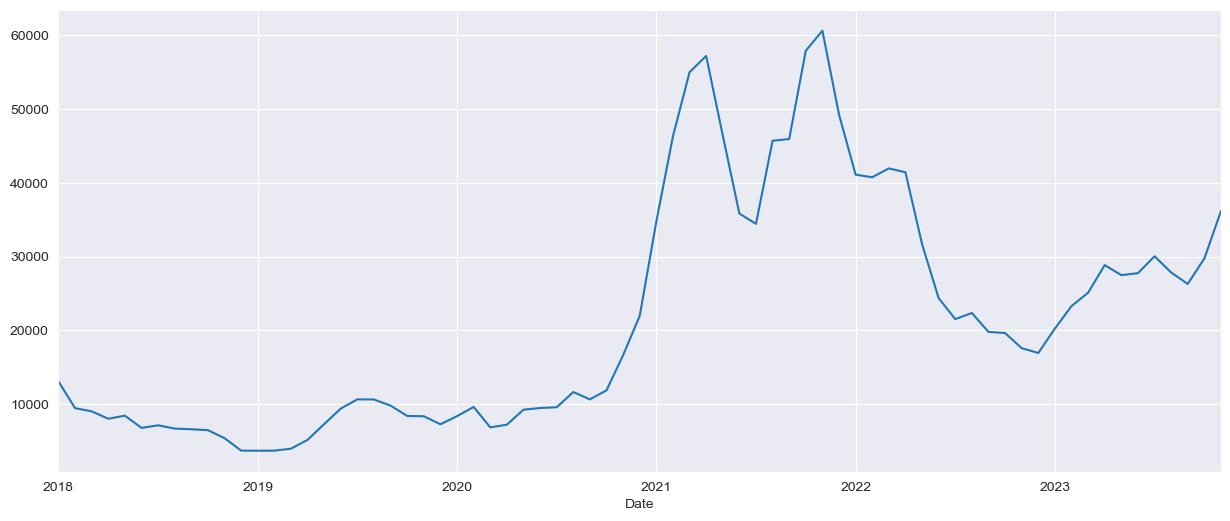

In [12]:
y.plot(figsize = (15, 6))
plt.show()

Time-series decompositon
It allows us to decompose our time series into three distinct components
Trend
Seasonality
Noise

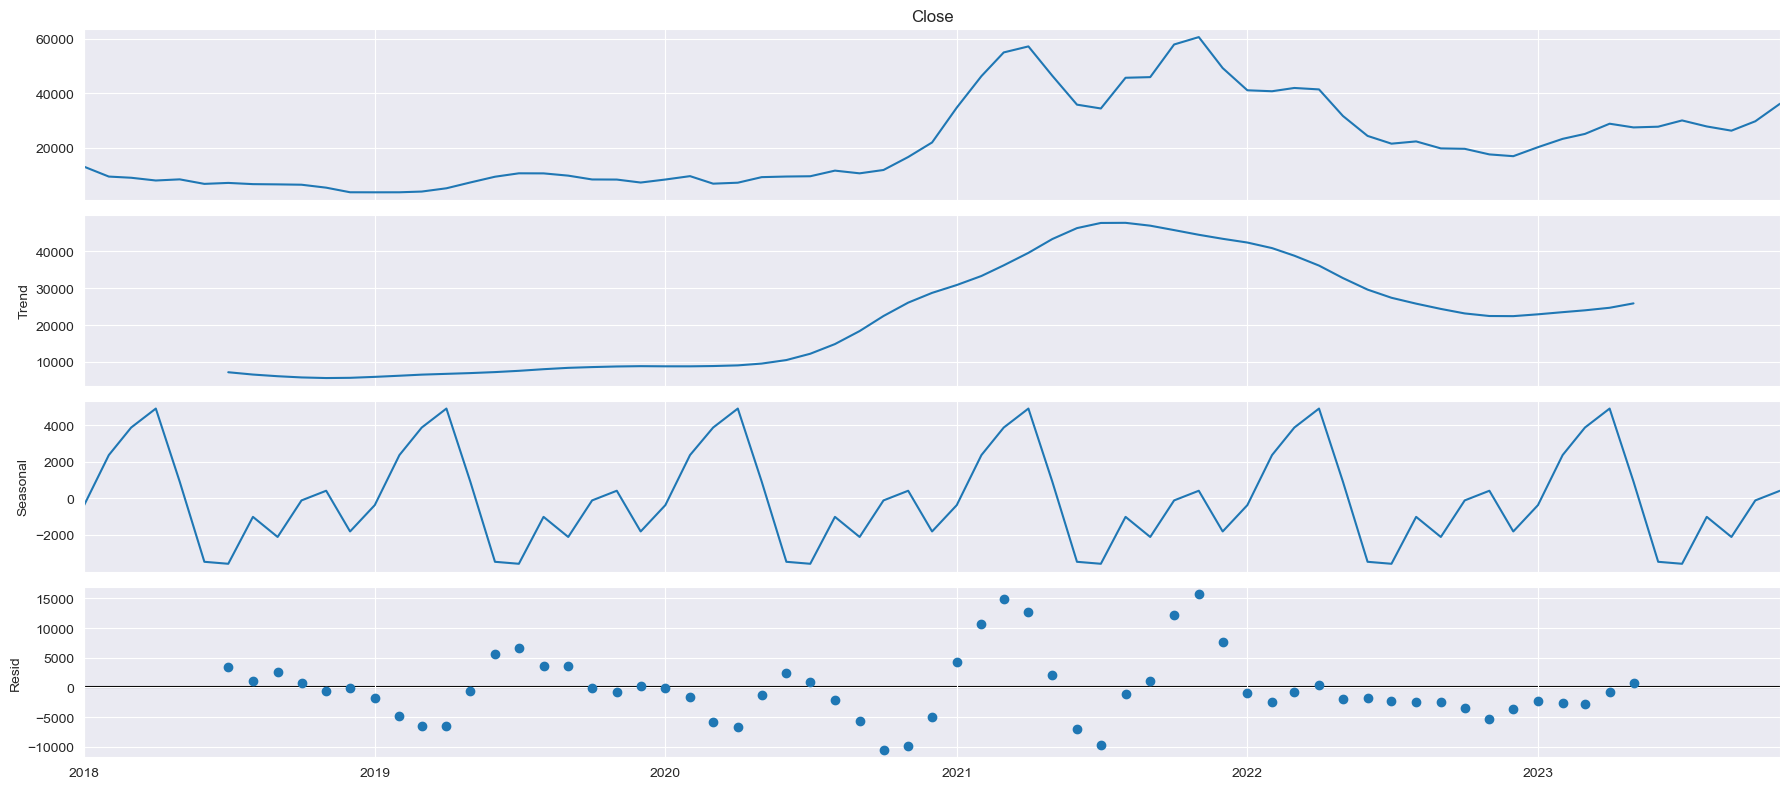

In [13]:
import statsmodels.api as sm
import matplotlib
from pylab import rcParams

rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model = 'additive')
fig = decomposition.plot()
plt.show()

Time series forecasting with ARIMA model
About ARIMA model

ARIMA stands for Autoregressive Integreted Moving Average
ARIMA models are denoted with the notation ARIMA(p, d, q)
These three parameters account for seasonality, trend, and noise in dat

In [14]:
import itertools
# set the typical ranges for p, d, q
p = d = q = range(0, 2)

#take all possible combination for p, d and q
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [15]:
# Using Grid Search find the optimal set of parameters that yields the best performance
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order = param, seasonal_order = param_seasonal, enforce_stationary = False,enforce_invertibility=False)
            result = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, result.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1650.472959816656
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1653.5469882103275
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1344.2565963535724
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1336.0974545691515
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1610.140360183635
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1621.0873007344662
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1338.8706979579565
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1338.045934533086
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1604.0811475189967
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1601.7275490516665
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1300.1938470377909
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1299.8441852347241
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1600.034233582765
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1601.7851486516765
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1300.029010422725
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1301.7769453457067
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1380.6433258842553
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1382.61505897799

C:\Users\allif\anaconda3\envs\sql\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1409.311506675191
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:1201.1644018474728
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1188.754028073401
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1386.673688552767
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1387.290895767273
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:1195.1435552655062
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:1179.0879434690535
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:1387.2378228605864
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1389.23590047582
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:1186.2844749081676
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1180.9268067922912
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1368.8452084394125
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1369.5318632530882
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:1169.961448503478
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1152.9662133532254
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:1369.531722071446
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1370.4763490110693
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:1160.9967489470575


In [16]:
#Fitting the ARIMA model using above optimal combination of p, d, q (optimal means combination at which we got lowest AIC score)

model = sm.tsa.statespace.SARIMAX(y, order = (1, 1, 1),
                                  seasonal_order = (1, 1, 0, 12)
                                 )
result = model.fit()
print(result.summary().tables[1])

# Saving the model using Joblib
import joblib
joblib.dump(result, 'BTC_sarimax_model.joblib')

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3642      0.227      1.602      0.109      -0.081       0.810
ma.L1          0.2358      0.187      1.260      0.208      -0.131       0.603
ar.S.L12      -0.4247      0.138     -3.079      0.002      -0.695      -0.154
sigma2      2.944e+07   2.26e-09    1.3e+16      0.000    2.94e+07    2.94e+07


['BTC_sarimax_model.joblib']

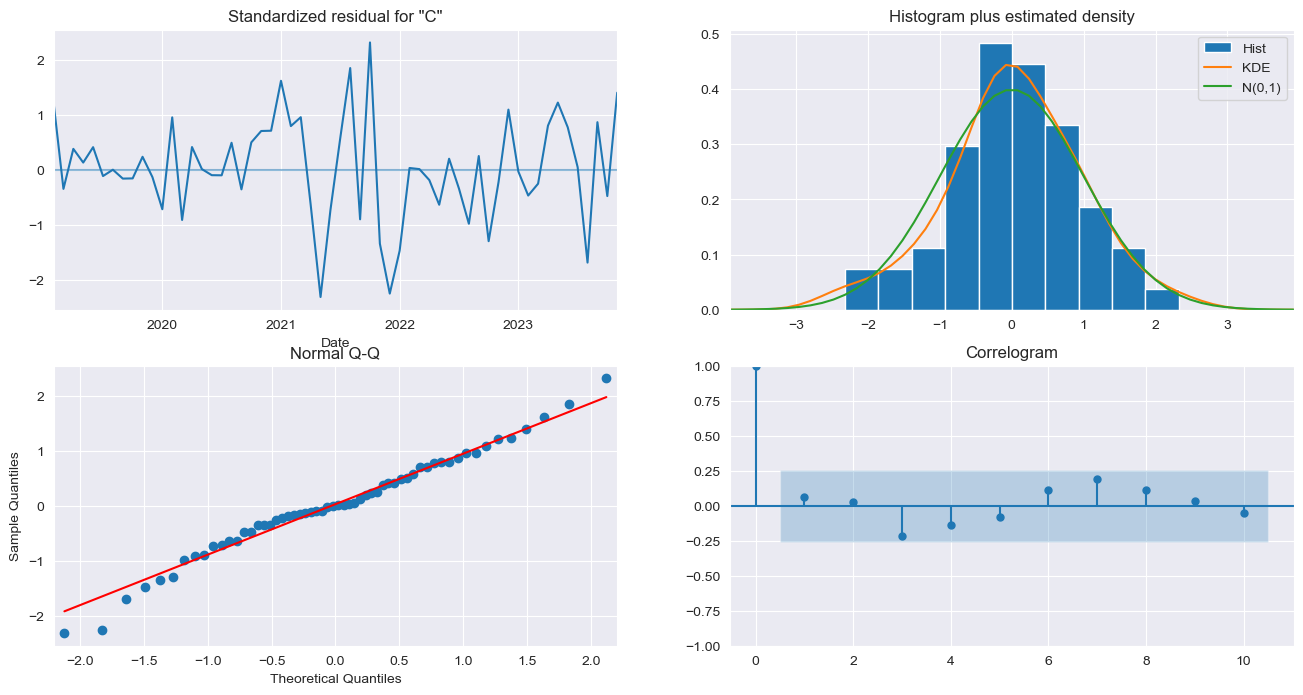

In [17]:
#run model diagnostic to investigate any unusual behavior
result.plot_diagnostics(figsize = (16, 8))
plt.show()

Validating Forecasts
To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2018–01–01 to the end of the data.

In [18]:
prediction = result.get_prediction(start = pd.to_datetime('2018-01-01 00:00:00+00:00'), dynamic = False)
prediction_ci = prediction.conf_int()
prediction_ci

,lower Close,upper Close
Date,,
2018-01-01 00:00:00+00:00,-14245.056907,14245.056907
2018-02-01 00:00:00+00:00,7679.847151,31858.023435
2018-03-01 00:00:00+00:00,-6011.303977,17935.339249
2018-04-01 00:00:00+00:00,-2416.881328,21519.032326
2018-05-01 00:00:00+00:00,-4633.147123,19302.238225
...,...,...
2023-07-01 00:00:00+00:00,19158.046404,40426.756348
2023-08-01 00:00:00+00:00,26393.105615,47661.815559
2023-09-01 00:00:00+00:00,10960.886333,32229.596278


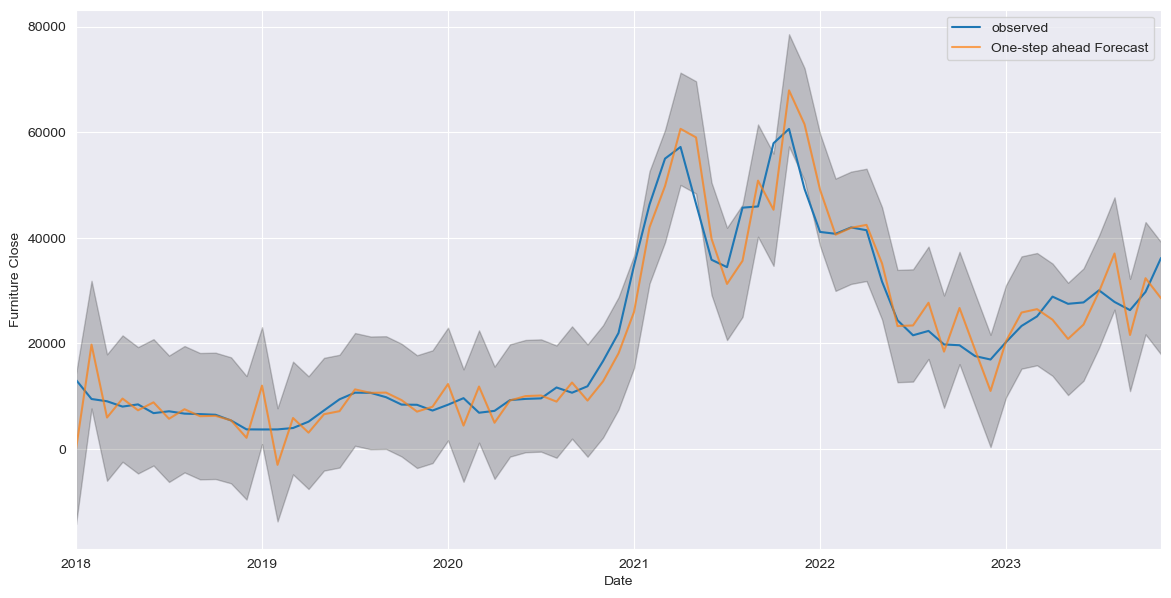

In [19]:
#Visualize the forecasting
ax = y['2018-01-01 00:00:00+00:00':].plot(label = 'observed')
prediction.predicted_mean.plot(ax = ax, label = 'One-step ahead Forecast', alpha = 0.7, figsize = (14, 7))
ax.fill_between(prediction_ci.index, prediction_ci.iloc[:, 0], prediction_ci.iloc[:, 1], color = 'k', alpha = 0.2)
ax.set_xlabel("Date")
ax.set_ylabel('Furniture Close')
plt.legend()
plt.show()

Error Analysis

In [20]:
# Evaluation metrics are Squared Mean Error(SME) and Root Mean Squared Error(RMSE)
y_hat = prediction.predicted_mean
y_truth = y['2018-01-01 00:00:00+00:00':]

mse = ((y_hat - y_truth) ** 2).mean()
rmse = np.sqrt(mse)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 25597385.01
The Root Mean Squared Error of our forecasts is 5059.39


Producing and Visualising my forecast

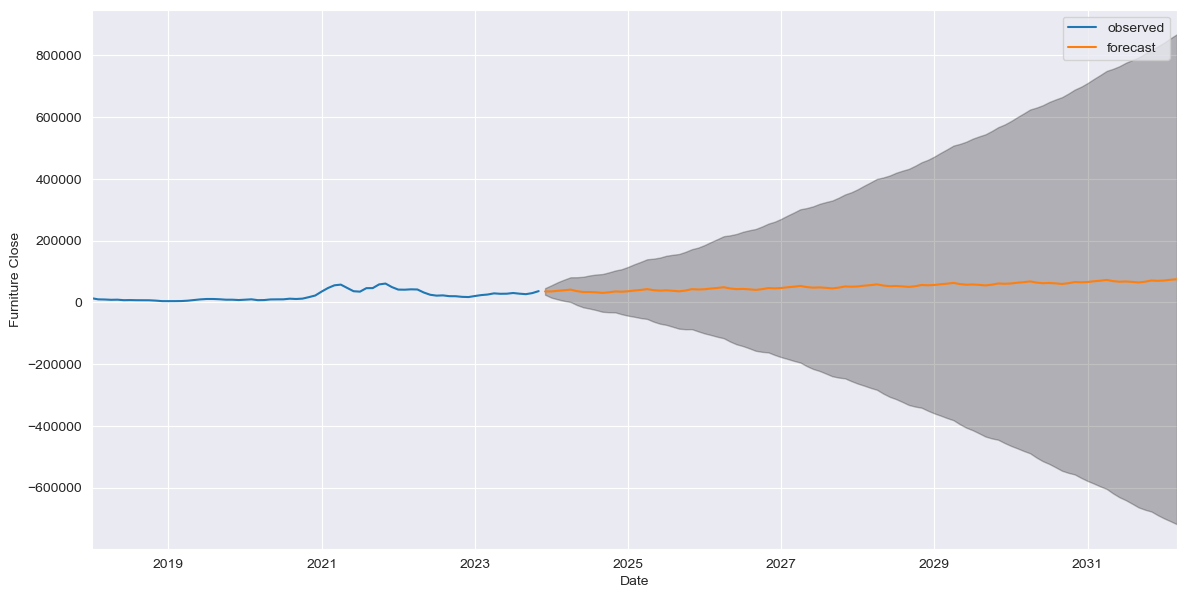

In [21]:
# forcasting for out of sample data
pred_uc = result.get_forecast(steps = 100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label = 'observed', figsize = (14, 7))
pred_uc.predicted_mean.plot(ax = ax, label = 'forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color = 'k', alpha = 0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Close')

plt.legend()
plt.show()

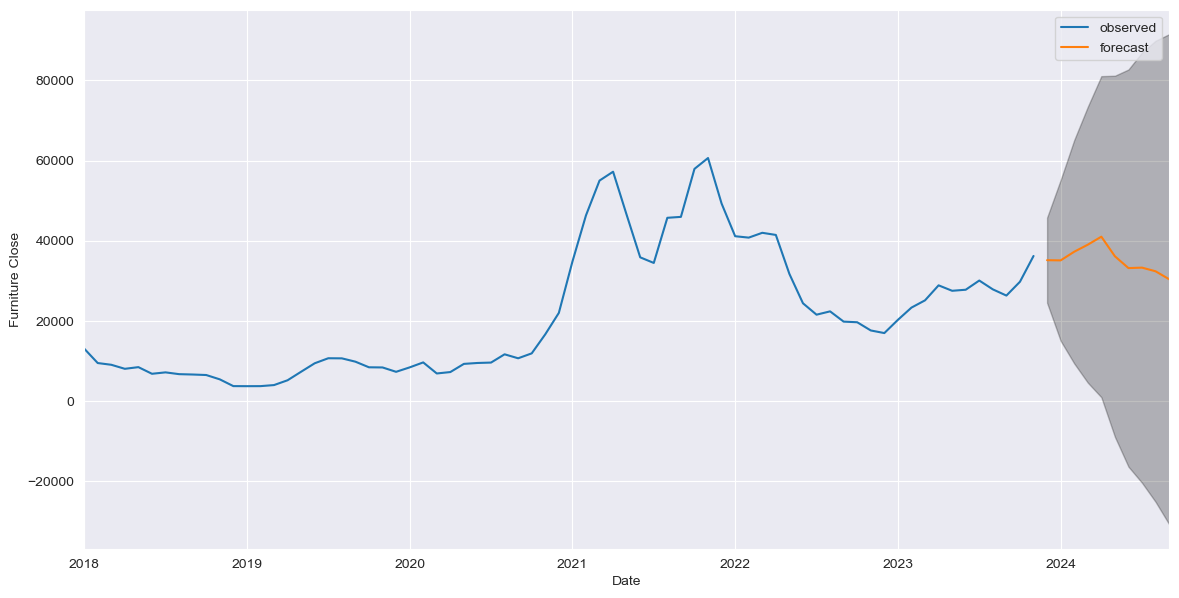

In [22]:

# Assuming you have already trained a time series forecasting model and obtained the forecasted mean
#Forecasting Future Closed Prices#
pred_uc = result.get_forecast(steps=10) # Adjust the number of steps as needed
pred_ci = pred_uc.conf_int()

#Plotting the Forecast#
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Close')

#Displaying the Plot#
plt.legend()
plt.show()


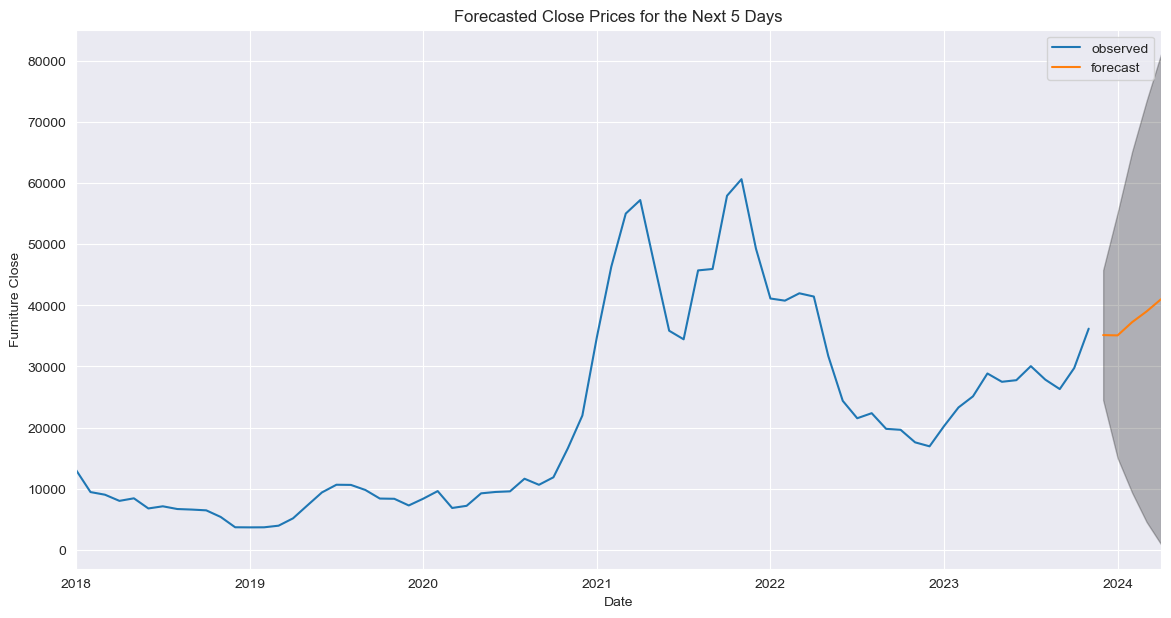

Forecasted Close Prices for the Next 5 Days:
2023-12-01 00:00:00+00:00    35134.553870
2024-01-01 00:00:00+00:00    35084.908536
2024-02-01 00:00:00+00:00    37243.408629
2024-03-01 00:00:00+00:00    38997.423060
2024-04-01 00:00:00+00:00    40997.145323
Freq: MS, Name: predicted_mean, dtype: float64


In [24]:
# Forecasting for the next 5 days
forecast_steps = 5
pred_uc = result.get_forecast(steps=forecast_steps)
pred_ci = pred_uc.conf_int()

# Plotting the Forecast
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Close')

# Displaying the Plot
plt.title('Forecasted Close Prices for the Next 5 Days')
plt.legend()
plt.show()

# Displaying the Forecast Values
forecast_values = pred_uc.predicted_mean
print(f"Forecasted Close Prices for the Next {forecast_steps} Days:\n{forecast_values}")

Forecasted Close Prices for the Specified Dates:
2023-12-01 00:00:00+00:00    35134.553870
2024-01-01 00:00:00+00:00    35084.908536
2024-02-01 00:00:00+00:00    37243.408629
2024-03-01 00:00:00+00:00    38997.423060
2024-04-01 00:00:00+00:00    40997.145323
Freq: MS, Name: predicted_mean, dtype: float64


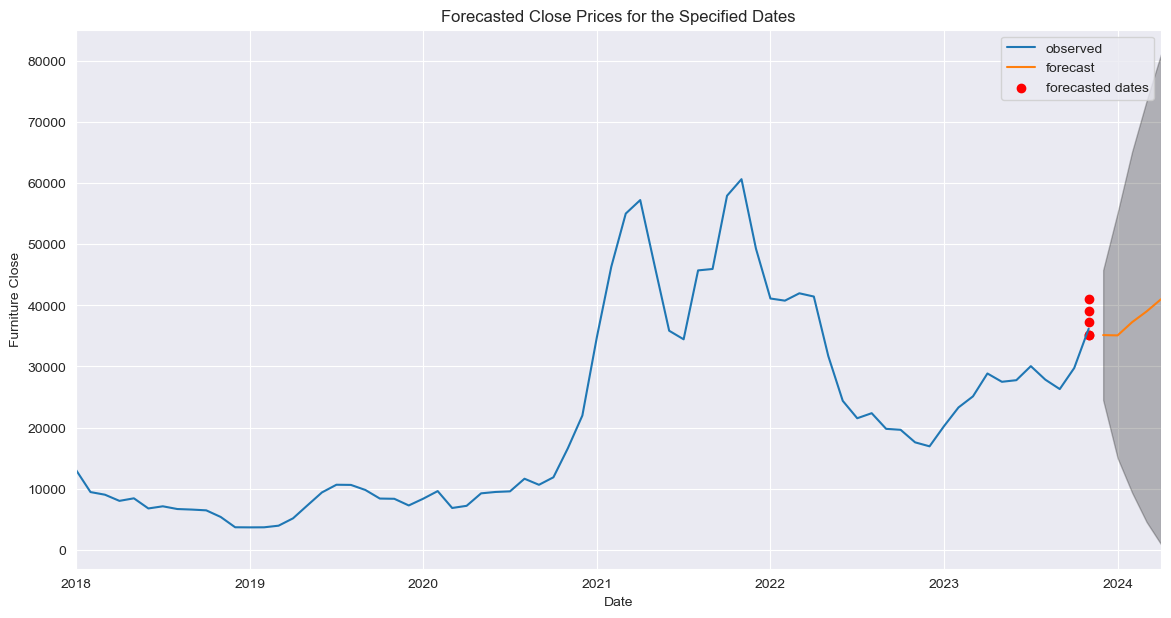

In [25]:
# Forecasting Future Closed Prices

# Forecasting for the specified dates
forecast_dates = ['2023-11-21 00:00:00+00:00', '2023-11-22 00:00:00+00:00', '2023-11-23 00:00:00+00:00', '2023-11-24 00:00:00+00:00', '2023-11-25 00:00:00+00:00']

# Convert forecast_dates to datetime format
forecast_dates = pd.to_datetime(forecast_dates)

# Forecast for the specified dates
pred_uc = result.get_forecast(steps=len(forecast_dates))
pred_ci = pred_uc.conf_int()

# Displaying the Forecast Values
forecast_values = pred_uc.predicted_mean
print(f"Forecasted Close Prices for the Specified Dates:\n{forecast_values}")

# Plotting the Forecast
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=0.25)
ax.scatter(forecast_dates, forecast_values, color='red', label='forecasted dates')
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Close')
plt.title('Forecasted Close Prices for the Specified Dates')
plt.legend()
plt.show()

Forecasted Close Prices for the Specified Dates:
2023-12-01 00:00:00+00:00    35134.553870
2024-01-01 00:00:00+00:00    35084.908536
2024-02-01 00:00:00+00:00    37243.408629
2024-03-01 00:00:00+00:00    38997.423060
2024-04-01 00:00:00+00:00    40997.145323
2024-05-01 00:00:00+00:00    36110.645928
Freq: MS, Name: predicted_mean, dtype: float64


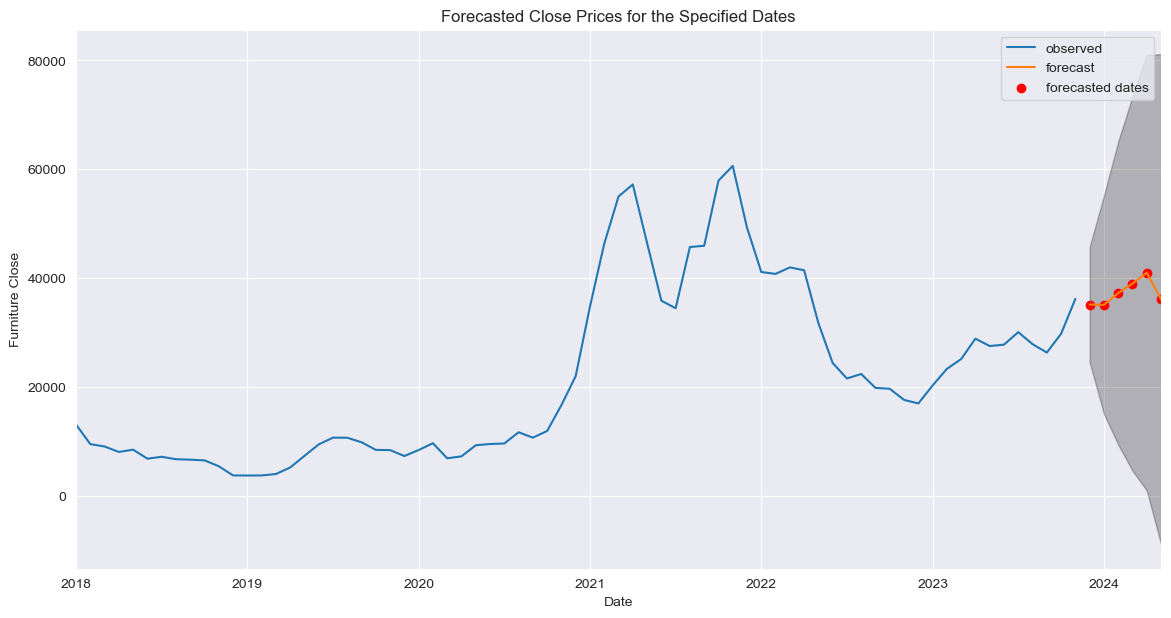

In [33]:
forecast_dates = ['2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01']

# Forecast for the specified dates
pred_uc = result.get_forecast(steps=len(forecast_dates))
pred_ci = pred_uc.conf_int()

# Displaying the Forecast Values
forecast_values = pred_uc.predicted_mean
print(f"Forecasted Close Prices for the Specified Dates:\n{forecast_values}")

# Plotting the Forecast
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=0.25)
ax.scatter(forecast_dates, forecast_values, color='red', label='forecasted dates')
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Close')
plt.title('Forecasted Close Prices for the Specified Dates')
plt.legend()
plt.show()

Forecasted Close Prices for the Specified Dates:
2023-12-01 00:00:00+00:00    35134.553870
2024-01-01 00:00:00+00:00    35084.908536
2024-02-01 00:00:00+00:00    37243.408629
Freq: MS, Name: predicted_mean, dtype: float64


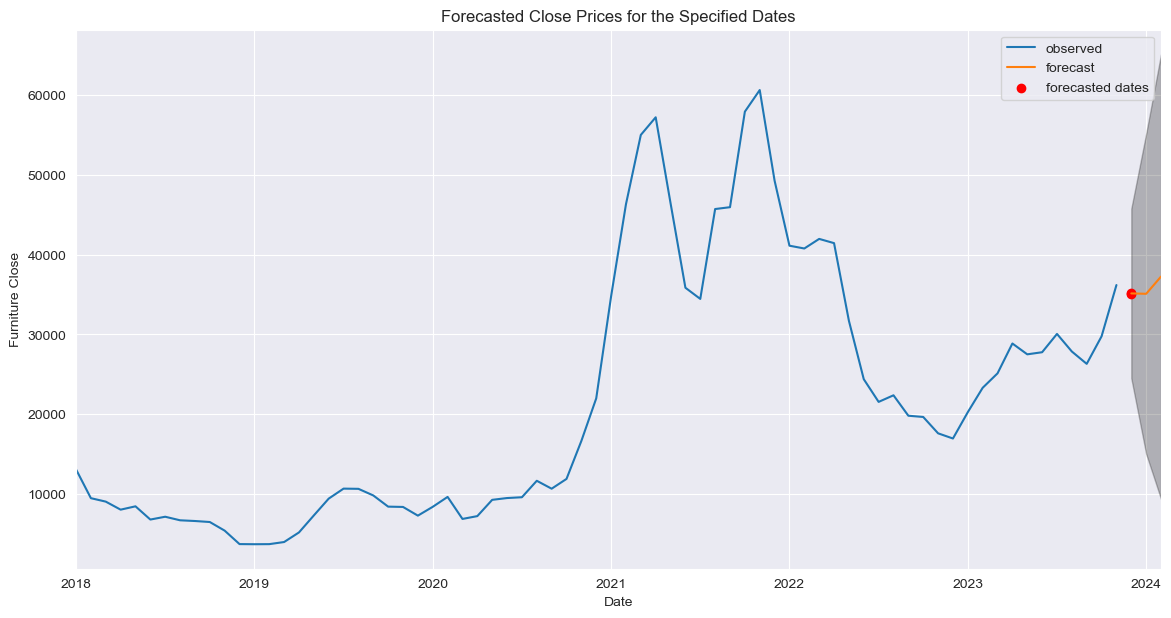

In [34]:
forecast_dates = ['2023-12-10', '2023-12-20', '2024-12-30']

# Forecast for the specified dates
pred_uc = result.get_forecast(steps=len(forecast_dates))
pred_ci = pred_uc.conf_int()

# Displaying the Forecast Values
forecast_values = pred_uc.predicted_mean
print(f"Forecasted Close Prices for the Specified Dates:\n{forecast_values}")

# Plotting the Forecast
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=0.25)
ax.scatter(forecast_dates, forecast_values, color='red', label='forecasted dates')
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Close')
plt.title('Forecasted Close Prices for the Specified Dates')
plt.legend()
plt.show()